# Workflow GPM

Import libraries to be used in the workflow

In [1]:
# plotting libraries
import matplotlib.pyplot as pl
import matplotlib as mpl
from matplotlib.collections import PatchCollection
from matplotlib.colors import from_levels_and_colors
from matplotlib.path import Path
import matplotlib.patches as patches
import matplotlib.cm as cm

# allows inline plotting in the notebook
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()

import os
import numpy as np
import datetime as dt
from osgeo import osr

import pandas as pd
import wradlib as wrl

# Import from external libraries
import io_func_PH
#from util_func_PH import *
#from external import *

#from pathlib import Path

# disable warnings
import warnings
warnings.filterwarnings('ignore')

# Setting up workflow

## Setting up parameters

In [2]:
# Space-born precipitation radar parameters
sr_pars = {"trmm": {
    "zt": 402500.,  # orbital height of TRMM (post boost)   APPROXIMATION!
    "dr": 250.,     # gate spacing of TRMM
}, "gpm": {
    "zt": 407000.,  # orbital height of GPM                 APPROXIMATION!
    "dr": 125.,      # gate spacing of GPM
}}

In [3]:
# Set parameters for this procedure

platf = "gpm"                # SR platform/product: one out of ["gpm", "trmm"]
ee = 0                        # elevation index
YEAR = '2015'
sweepnum = ['02','03','04','05'][ee]
radarname = 'SUB'

bw_sr = 0.71                  # SR beam width
zt = sr_pars[platf]["zt"]     # SR orbit height (meters)
dr_sr = sr_pars[platf]["dr"]  # SR gate length (meters)

## Define and read data

### Define GPM Data set

In [12]:
gpm_file = '../data/gpm/2A-PH-SUBTAG.GPM.Ku.V7-20170308.20151001-S185850-E185953.009041.V05A.HDF5'

### Define radar data set

In [13]:
gr2gpm_file = [os.path.join('../data/radar',f) for f in os.listdir('../data/radar') if '2015' in f]

### Read SR and GR data

In [14]:
sr_data, gr_data = io_func_PH.read_data_sr_gr(platf, ee, gpm_file, gr2gpm_file)

### Read beam blockage quality map

In [15]:
qual_BBF, a_BBF = wrl.io.from_hdf5('../data/bbf/SUB_qual_'+sweepnum+'-ZH_150km_r250m_BBF.hdf5')

In [83]:
if qual_BBF.shape != gr_data['refl'][ee].shape:
    qual_BBF = qual_BBF[:,:gr_data['refl'][ee].shape[1]]
else:
    pass 

In [84]:
qual_BBF.shape

(360, 480)

# Data Handling

## Extract relevant GR data and meta-data


In [85]:
# number of rays in gr sweep
try:
    nray_gr = gr_data['nbeam'].astype("i4")[ee]
except IndexError:
    raise RadarFileError
# number of gates in gr beam
ngate_gr = gr_data['ngate'].astype("i4")[ee]
# number of sweeps
nelev = gr_data['ntilt']
# elevation of sweep (degree)
elev_gr = gr_data['elang'][ee]
# gate length (meters)
dr_gr = gr_data['dr'][ee]
# reflectivity array of sweep
ref_gr = gr_data['refl'][ee]
# sweep datetime stamp
date_gr = gr_data['sdate'][ee]
# range of first gate
r0_gr = gr_data['r0'][ee]                    
# azimuth angle of first beam
a0_gr = gr_data['a0'][ee]
# Longitude of GR
lon0_gr = gr_data['lon']
# Latitude of GR
lat0_gr = gr_data['lat']
# Altitude of GR (meters)
alt0_gr = gr_data['alt']
# Beam width of GR (degree)
bw_gr = 1.

## Calculate GR Bounding Box

In [86]:
coord = wrl.georef.sweep_centroids(nray_gr, dr_gr, ngate_gr, elev_gr)
coords = wrl.georef.spherical_to_proj(coord[..., 0], 
                                      np.degrees(coord[..., 1]),
                                      coord[..., 2], 
                                      (lon0_gr, lat0_gr, alt0_gr))
lon = coords[..., 0]
lat = coords[..., 1]
alt = coords[..., 2]
bbox = wrl.zonalstats.get_bbox(lon, lat)

## Extract relevant SR data and meta-data    

In [87]:
# Longitudes of SR scans
sr_lon = sr_data['lon']
# Latitudes of SR scans
sr_lat = sr_data['lat']
# Precip flag
pflag = sr_data['pflag']
# Number of scans on SR data
nscan_sr= sr_data['nscan']
# Number of rays in one SR scan
nray_sr = sr_data['nray']
# Number of gates in one SR ray
ngate_sr = sr_data['nbin']

In [88]:
# Sample ID (from filename)
sampleid = gpm_file[::-1][10:16][::-1]

## Georeferencing

### Set fundamental georeferencing parameters

In [89]:
# Calculate equivalent earth radius
wgs84 = wrl.georef.get_default_projection()
re1 = wrl.georef.get_earth_radius(lat0_gr, wgs84) 
a = wgs84.GetSemiMajor()
b = wgs84.GetSemiMinor()

# Set up aeqd-projection gr-centered
rad = wrl.georef.proj4_to_osr(('+proj=aeqd +lon_0={lon:f} ' + 
                                   '+lat_0={lat:f} +a={a:f} ' +
                                   '+b={b:f}').format(lon=lon0_gr,
                                                      lat=lat0_gr,
                                                      a=a, b=b))
re2 = wrl.georef.get_earth_radius(lat0_gr, rad)

### Georeference GR data

In [90]:
# create gr range and azimuth arrays
rmax_gr = r0_gr + ngate_gr * dr_gr
r_gr = np.arange(0, ngate_gr) * dr_gr + dr_gr/2.
az_gr = np.arange(0, nray_gr) - a0_gr

# create gr polar grid and calculate aeqd-xyz coordinates
gr_polargrid = np.meshgrid(r_gr, az_gr)
gr_xyz, rad = wrl.georef.spherical_to_xyz(gr_polargrid[0], gr_polargrid[1], elev_gr, (lon0_gr, lat0_gr, alt0_gr ))

# create gr poygon array in aeqd-xyz-coordinates
gr_poly, rad1 = wrl.georef.spherical_to_polyvert(r_gr, az_gr, elev_gr, (lon0_gr, lat0_gr, alt0_gr))
gr_poly.shape = (nray_gr, ngate_gr, 5, 3)

# get radar domain (outer ring)
gr_domain = gr_xyz[:,-1,0:2]
gr_domain = np.vstack((gr_domain, gr_domain[0]))

### Georeference SR data

In [91]:
sr_x, sr_y = wrl.georef.reproject(sr_lon, sr_lat, 
                                      projection_source=wgs84, 
                                      projection_target=rad)
sr_xy = np.dstack((sr_x, sr_y))

### Subset relevant SR data

In [92]:
# Create ZonalData for spatial subsetting (inside GR range domain)
precip_mask = (pflag == 2) & wrl.zonalstats.get_clip_mask(sr_xy, gr_domain, rad)

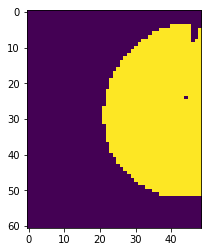

In [93]:
pl.imshow(precip_mask)

### SR Parallax Correction

In [94]:
# use localZenith Angle
alpha = sr_data['zenith']
beta = abs(-17.04 + np.arange(nray_sr) * bw_sr)

# Correct for parallax, get 3D-XYZ-Array
#   xyzp_sr: Parallax corrected xyz coordinates
#   r_sr_inv: range array from ground to SR platform
#   zp: SR bin altitudes
xyp_sr, r_sr_inv, z_sr = wrl.georef.correct_parallax(sr_xy, ngate_sr, dr_sr, alpha)
xyzp_sr = np.concatenate((xyp_sr, z_sr[..., np.newaxis]),
                   axis=-1)

### Compute spherical coordinates of SR bins with regard to GR

In [95]:
r_sr, az_sr, elev_sr = wrl.georef.xyz_to_spherical(xyzp_sr, alt0_gr, proj=rad)    
mask = (elev_sr > (1.0 - bw_gr/2.)) & (elev_sr < (1.0 + bw_gr/2.))

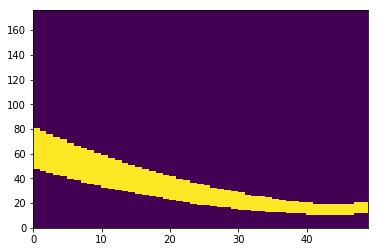

In [96]:
pl.figure()
pl.pcolormesh(mask[40,:,:].T)

### Compute SR and GR pulse volumes

#### Calculate distance from orbit $r_s$

In [97]:
rs = wrl.georef.dist_from_orbit(zt, alpha, beta, r_sr_inv, re1)

#### SR pulse volume

In [98]:
# Small anngle approximation
vol_sr2  = np.pi * dr_sr * rs**2 * np.radians(bw_sr / 2.)**2
# Or using wradlib's native function
vol_sr = wrl.qual.pulse_volume(rs, dr_sr, bw_sr)

#### GR pulse volume

In [99]:
# GR pulse volumes
#   along one beam
vol_gr = wrl.qual.pulse_volume(r_gr, dr_gr, bw_gr)
#   with shape (nray_gr, ngate_gr)
vol_gr = np.repeat(vol_gr, nray_gr).reshape((nray_gr, ngate_gr), order="F")

#### Calculate horizontal and vertical dimensions $R_s$ and $D_s$ of SR bins

In [100]:
Rs = 0.5 * (1 +  np.cos(np.radians(alpha)))[:,:,np.newaxis] * rs * np.tan(np.radians(bw_sr/2.))
Ds = dr_sr / np.cos(np.radians(alpha))
Ds = np.broadcast_to(Ds[..., np.newaxis], Rs.shape)

### Median Brightband Width/Height

In [101]:
ratio, ibb = wrl.qual.get_bb_ratio(sr_data['zbb'], sr_data['bbwidth'], sr_data['quality'], z_sr)
zbb = sr_data['zbb'].copy()
zbb[~ibb] = np.nan

### Convert SR Ku reflectivities to S-band 

(Based on [Cao et.al (2013)](http://dx.doi.org/10.1002/jgrd.50138))

In [102]:
ref_sr = sr_data['refl'].filled(np.nan)      # uncorrected
ref_sr_ss = np.zeros_like(ref_sr) * np.nan   # corrected (snow)
ref_sr_sh = np.zeros_like(ref_sr) * np.nan   # corrected (hail)

a_s, a_h = (wrl.trafo.ku2s.snow, wrl.trafo.ku2s.hail) 

ia = (ratio >= 1)
ref_sr_ss[ia] = ref_sr[ia] + wrl.util.calculate_polynomial(ref_sr[ia], a_s[:,10])
ref_sr_sh[ia] = ref_sr[ia] + wrl.util.calculate_polynomial(ref_sr[ia], a_h[:,10])
ib = (ratio <= 0)
ref_sr_ss[ib] = ref_sr[ib] + wrl.util.calculate_polynomial(ref_sr[ib], a_s[:,0])
ref_sr_sh[ib] = ref_sr[ib] + wrl.util.calculate_polynomial(ref_sr[ib], a_h[:,0])
im = (ratio > 0) & (ratio < 1)
ind = np.round(ratio[im] * 10).astype(np.int)
ref_sr_ss[im] = ref_sr[im] + wrl.util.calculate_polynomial(ref_sr[im], a_s[:,ind])
ref_sr_sh[im] = ref_sr[im] + wrl.util.calculate_polynomial(ref_sr[im], a_h[:,ind])

# Jackson Tan's fix for C-band
is_cband = False
if (is_cband):
    deltas = (ref_sr_ss - ref_sr) * 5.3 / 10.0
    ref_sr_ss = outref_sr + deltas
    deltah = (ref_sr_sh - ref_sr) * 5.3 / 10.0
    ref_sr_sh = ref_sr + deltah

ref_sr_ss[ref_sr < 0] = np.nan

### Convert S-band GR reflectivities to Ku-band

Using the method of [Liao and Meneghini (2009)](http://dx.doi.org/10.1175/2008JAMC1974.1))

In [103]:
# Convert S-band GR reflectivities to Ku-band using method of Liao and Meneghini (2009)
ref_gr_ku = np.zeros_like(ref_gr) * np.nan

# Snow
ia = ( gr_xyz[...,2] >= np.nanmean(zbb) )
#ref_gr_ku[ia] = wrl.trafo.ku2s.snow[0] + wrl.trafo.ku2s.snow[1]*ref_gr[ia] + wrl.trafo.ku2s.snow[2]*ref_gr[ia]**2
ref_gr_ku[ia] = wrl.util.calculate_polynomial(ref_gr[ia], wrl.trafo.s2ku.snow)
# Rain
ib = ( gr_xyz[...,2] < np.nanmean(zbb) )
#ref_gr_ku[ib] = wrl.trafo.ku2s.rain[0] + wrl.trafo.ku2s.rain[1]*ref_gr[ia] + wrl.trafo.ku2s.rain[2]*ref_gr[ia]**2
ref_gr_ku[ib] = wrl.util.calculate_polynomial(ref_gr[ib], wrl.trafo.s2ku.rain)

# Jackson Tan's fix for C-band
is_cband = False
if (is_cband):
    delta = (ref_gr_ku - ref_gr) * 5.3/10.0
    ref_gr_ku = ref_gr + delta

## Matching SR/GR
### Identify which SR rays actually intersect with the GR sweep
Based on the above criteria (in radar range, precipitating SR profile) and based on SR elevation angle (with regard to GR).

In [104]:
# First assumption: no valid SR bins (all False)
valid = np.asarray(elev_sr, dtype=np.bool)==False
# SR is inside GR range and is precipitating
iscan = precip_mask.nonzero()[0]
iray = precip_mask.nonzero()[1]
valid[iscan,iray] = True
# SR bins intersect with GR sweep
valid = valid & (elev_sr >= (elev_gr-bw_gr/2.)) & (elev_sr <= (elev_gr+bw_gr/2.))
above_18 = valid & (ref_sr >= 18)
# Number of matching SR bins per profile
nvalids = np.sum(valid, axis=2)
# scan and ray indices for profiles with at least one valid bin
vscan, vray = np.where(nvalids>0)
# number of profiles with at least one valid bin
nprof = len(vscan)

#### Averaging SR parameters

In [105]:
# average coordinates
xyz_v1 = xyzp_sr.copy()
xyz_v1[~valid] = np.nan
xyz_c1 = xyzp_sr.copy()
xyz_c1[~valid] = 0
c = np.count_nonzero(xyz_c1[..., 0], axis=2)
ntotsr = c[vscan, vray]
xyz_m1 = np.nanmean(xyz_v1,axis=2)
xyz = xyz_m1[vscan, vray]

# get number of SR bins above 18 dBZ
xyz_c2 = xyzp_sr.copy()
xyz_c2[~above_18] = 0
c2 = np.count_nonzero(xyz_c2[..., 0], axis=2)
ngoodsr = c2[vscan, vray]

# approximate Rs 
rs_v1 = Rs.copy()
rs_v1[~valid] = np.nan
rs_m1 = np.nanmax(rs_v1, axis=2)
rs_prof = rs_m1[vscan, vray]
ds = rs_prof

# approximate Ds
ds_v1 = Ds.copy()
ds_v1[~valid] = np.nan
ds_m1 = np.nansum(ds_v1, axis=2)
ds_prof = ds_m1[vscan, vray]
dz = ds_prof

# approximate Vs
vs_v1 = vol_sr.copy()
vs_v1[~valid] = np.nan
vs_m1 = np.nansum(vs_v1, axis=2)
vs_prof = vs_m1[vscan, vray]
volsr1 = vs_prof

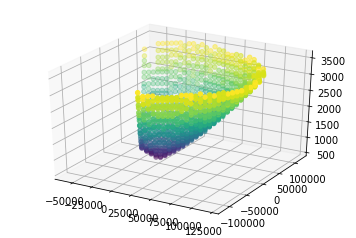

In [106]:
from mpl_toolkits.mplot3d import Axes3D
fig = pl.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xyz_m1[..., 0], xyz_m1[..., 1], xyz_m1[..., 2], c=c.ravel())

In [107]:
# ratio of accepted bins and total bins SR
ratio_sr_good_tot = ngoodsr/ntotsr.astype(float)

#### Calculate spherical coordinates of SR sample volume with respect to GR

In [108]:
r_sr, az_sr, el_rs = wrl.georef.xyz_to_spherical(xyz, alt0_gr, proj=rad)

#### Average SR reflectivity

In [109]:
# uncorrected
ref_sr_1 = wrl.trafo.idecibel(ref_sr)
ref_sr_1[~above_18] = np.nan
refsr1a = np.nanmean(ref_sr_1, axis=2)[vscan,vray]
refsr1a = wrl.trafo.decibel(refsr1a)

# snow
ref_sr_2 = wrl.trafo.idecibel(ref_sr_ss)
ref_sr_2[~above_18] = np.nan
refsr2a = np.nanmean(ref_sr_2, axis=2)[vscan,vray]
refsr2a = wrl.trafo.decibel(refsr2a)

# hail
ref_sr_3 = wrl.trafo.idecibel(ref_sr_sh)
ref_sr_3[~above_18] = np.nan
refsr3a = np.nanmean(ref_sr_3, axis=2)[vscan,vray]
refsr3a = wrl.trafo.decibel(refsr3a)

In [110]:
# get the precipitation type based on SR
type_sr = sr_data['ptype'][vscan,vray]

In [111]:
# get the bright band membership based on PR
ratio_c1 = ratio.copy()
ratio_c1[~valid] = np.nan
bb_ratio = np.nanmean(ratio_c1,axis=2)
bb_sr = bb_ratio[vscan, vray]

### Identify which GR bins actually intersect with the SR footprint
#### Create Zonal Data Source of matching SR profiles

In [112]:
zds = wrl.zonalstats.DataSource(xyz[:, 0:2].reshape(-1, 2), rad)

#### Create SR beam polygons using $R_s$

In [113]:
tmp_trg_lyr = zds.ds.GetLayer()
trg_poly = []
for i, feat in enumerate(tmp_trg_lyr):
    geom = feat.GetGeometryRef().Buffer(rs_prof[i])
    poly = wrl.georef.ogr_to_numpy(geom)
    trg_poly.append(poly)

#### Create ZonalDataPoly for GR and SR profiles  

In [114]:
%%time
zdp = wrl.zonalstats.ZonalDataPoly(gr_poly[..., 0:2].reshape(-1, 5, 2), trg_poly, srs=rad)
zdp.dump_vector('m3d_zonal_poly_{0}_{1}'.format(platf,YEAR))
obj3 = wrl.zonalstats.GridCellsToPoly('m3d_zonal_poly_{0}_{1}'.format(platf,YEAR))

Wall time: 2min 35s


#### Average GR volume and reflectivity

In [115]:
# set GR bins below 0 dBZ to 0 dBZ (according to Morris and Schwaller 2011)
ref_gr[ref_gr < 0] = 0
ref_gr_ku[ref_gr_ku < 0] = 0

volgr1 = np.array([np.sum(vol_gr.ravel()[obj3.ix[i]])
                   for i in np.arange(len(obj3.ix))[~obj3.check_empty()]])

ref_gr_i = wrl.trafo.idecibel(ref_gr.ravel())
ref_gr_ku_i = wrl.trafo.idecibel(ref_gr_ku.ravel())
refgr1a = np.array([np.nanmean(ref_gr_i[obj3.ix[i]])
             for i in np.arange(len(obj3.ix))[~obj3.check_empty()]])
refgr1a = wrl.trafo.decibel(refgr1a)
refgr2a = np.array([np.nanmean(ref_gr_ku_i[obj3.ix[i]])
             for i in np.arange(len(obj3.ix))[~obj3.check_empty()]])
refgr2a = wrl.trafo.decibel(refgr2a)

In [116]:
# ratio of accepted bins and total bins GR
gr_ref = np.array([ref_gr.ravel()[obj3.ix[i]]
                   for i in np.arange(len(obj3.ix))[~obj3.check_empty()]])
# ntotalgr = np.array([len(item) for item in gr_ref]) # count includes NaNs
ntotalgr = np.array([np.count_nonzero(~np.isnan(item)) for item in gr_ref]) # count excludes NaNs
ngoodgr = np.array([len(item[item>=15]) for item in gr_ref])
ratio_gr_good_tot = ngoodgr/ntotalgr.astype(float)

#### Calculate quality values for each matched volume

In [117]:
# BBF
qualgr_BBF = np.array([np.nanmin(qual_BBF.ravel()[obj3.ix[i]])
             for i in np.arange(len(obj3.ix))[~obj3.check_empty()]])

# STORE OUTPUT IN PANDAS DATAFRAME

In [118]:
emptydata = np.empty((len(refgr1a.ravel()), 20))
emptydata[:] = np.nan

df = pd.DataFrame(emptydata, columns=['sample_id','sr_date','gr_date','time_diff','ee', 'elev' ,
                                      'sr_ref','sr_ref_ss','sr_ref_sh','gr_ref','gr_ref_ku',
                                      'lat','lon','alt','quality_BBF','pflag', 'ptype',
                                      'bb','ratio_sr','ratio_gr'])
# convert sample_id column into string
df.sample_id = df.sample_id.astype(str)

for i in df.index:
    df.set_value(i, 'sample_id', sampleid)
    df.set_value(i, 'sr_date', sr_data['date'][0])
    df.set_value(i, 'gr_date', gr_data['date'])
    df.set_value(i, 'time_diff', abs(sr_data['date'][0] - gr_data['date']).seconds)
    df.set_value(i, 'ee', ee)
    df.set_value(i, 'elev', elev_gr)
    df.set_value(i, 'sr_ref', refsr1a[i])   # uncorrected SR
    df.set_value(i, 'sr_ref_ss', refsr2a[i])   # corrected SR (Ku-S) snow
    df.set_value(i, 'sr_ref_sh', refsr3a[i])   # corrected SR (Ku-S) hail
    df.set_value(i, 'gr_ref', refgr1a[i])   # uncorrected GR
    df.set_value(i, 'gr_ref_ku', refgr2a[i])   # corrected GR (S-Ku)
    df.set_value(i, 'lon', xyz[...,0][i])
    df.set_value(i, 'lat', xyz[...,1][i])
    df.set_value(i, 'alt', xyz[...,2][i])
    df.set_value(i, 'quality_BBF', qualgr_BBF[i])
    df.set_value(i, 'pflag', np.sum(precip_mask))
    df.set_value(i, 'ptype', type_sr[i])
    df.set_value(i, 'bb', bb_sr[i])
    df.set_value(i, 'ratio_sr', ratio_sr_good_tot[i])
    df.set_value(i, 'ratio_gr', ratio_gr_good_tot[i])




In [119]:
dbfilename = platf + '_' + radarname.lower() + '_' + \
                     dt.datetime.strftime(sr_data['date'][0], '%Y%m%d_%H%M%S') + '.hdf5'
df.to_hdf(os.path.join('../output/matching', dbfilename), 'dataframe')

In [120]:
df.tail()

,sample_id,sr_date,gr_date,time_diff,ee,elev,sr_ref,sr_ref_ss,sr_ref_sh,gr_ref,gr_ref_ku,lat,lon,alt,quality_BBF,pflag,ptype,bb,ratio_sr,ratio_gr
1075,009041,2015-10-01 18:58:54.644000,2015-10-01 19:00:05,70.0,0.0,1.0,30.633671,30.151222,30.151222,NaN,NaN,-105057.006517,47549.627477,3319.441415,0.0,1080.0,1.0,-1.471718,1.0,NaN
1076,009041,2015-10-01 18:58:54.644000,2015-10-01 19:00:05,70.0,0.0,1.0,26.961781,26.656673,26.656673,NaN,NaN,-107393.251191,42800.556450,3367.517412,0.0,1080.0,1.0,-1.402138,1.0,NaN
1077,009041,2015-10-01 18:58:54.644000,2015-10-01 19:00:05,70.0,0.0,1.0,28.944769,28.544785,28.544785,NaN,NaN,-109741.438624,38016.041039,3354.695439,0.0,1080.0,1.0,-1.420695,1.0,NaN
1078,009041,2015-10-01 18:58:54.644000,2015-10-01 19:00:05,70.0,0.0,1.0,25.993080,25.735088,25.735088,NaN,NaN,-112133.932111,33127.153479,3341.103047,0.0,1080.0,1.0,-1.440367,1.0,NaN
1079,009041,2015-10-01 18:58:54.644000,2015-10-01 19:00:05,70.0,0.0,1.0,24.166798,23.992565,23.990419,NaN,NaN,-114509.446230,28262.573447,3445.823118,0.0,1080.0,1.0,-1.288806,1.0,NaN
